In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
#from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


2022-06-14 04:55:00.291092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-14 04:55:00.291122: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv("../datasets/TON_IoT-Datasets/Train_Test_datasets/Train_Test_IoT_dataset/Train_Test_IoT_Modbus.csv")
df.head()
reduced_df = df[["FC1_Read_Input_Register", "FC2_Read_Discrete_Value", "FC3_Read_Holding_Register", "FC4_Read_Coil", "label"]]
df = reduced_df

In [3]:
# Percentage malware
perc = len(df.loc[df['label']==1])/len(df)
print(perc)

0.3151489061949673


In [4]:
# Balance dataset
num_anom = len(df.loc[df['label']==1])
df_anom = df.loc[df['label']==1]
df_normal = df.loc[df['label']==0]
df_normal = df_normal.sample(num_anom, replace=False)
df_concated = pd.concat([df_normal, df_anom])
df = df_concated

# Percentage malware
perc = len(df.loc[df['label']==1])/len(df)
print(perc)

0.5


In [5]:
labels = df.pop('label')

In [6]:
# Normalize
data_scaled = df.copy()
min_max_scaler = MinMaxScaler()
#data_scaled[["src_port", "dst_port", "src_bytes", "dst_bytes", "missed_bytes"]] = min_max_scaler.fit_transform(data_scaled[["src_port", "dst_port", "src_bytes", "dst_bytes", "missed_bytes"]])
data_scaled[data_scaled.columns] = min_max_scaler.fit_transform(data_scaled[data_scaled.columns])

In [7]:
print(data_scaled.shape)

(32212, 4)


In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(data_scaled, labels, test_size=0.2, random_state=21)

In [9]:
# Separe normal and anomaly classes
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

In [10]:
print(normal_train_data.iloc[0])

FC1_Read_Input_Register      0.476155
FC2_Read_Discrete_Value      0.677165
FC3_Read_Holding_Register    0.798590
FC4_Read_Coil                0.062120
Name: 10678, dtype: float64


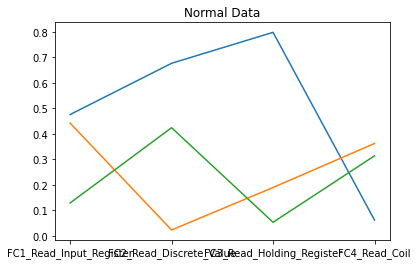

In [11]:
plt.plot(normal_train_data.iloc[0])
plt.plot(normal_train_data.iloc[1])
plt.plot(normal_train_data.iloc[2])
plt.title("Normal Data")
plt.show()

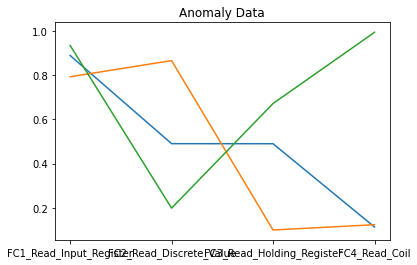

In [12]:
plt.plot(anomalous_train_data.iloc[0])
plt.plot(anomalous_train_data.iloc[1])
plt.plot(anomalous_train_data.iloc[2])
plt.title("Anomaly Data")
plt.show()

In [13]:
train_data = np.array(train_data)
normal_train_data = np.array(normal_train_data)
normal_test_data = np.array(normal_test_data)
anomalous_train_data = np.array(anomalous_train_data)
anomalous_test_data = np.array(anomalous_test_data)

In [14]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(8, activation="relu")
              ])
    self.decoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(4, activation="sigmoid")
              ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [15]:
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss="mae")
history = model.fit(normal_train_data, normal_train_data, epochs=50, batch_size=120,
                    validation_data=(train_data, train_data),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )

Epoch 1/50


2022-06-14 04:55:03.088987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-14 04:55:03.089021: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-14 04:55:03.089038: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian): /proc/driver/nvidia/version does not exist
2022-06-14 04:55:03.089229: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


108/108 [==============================] - 1s 4ms/step - loss: 0.2500 - val_loss: 0.2494
Epoch 2/50
108/108 [==============================] - 0s 3ms/step - loss: 0.2497 - val_loss: 0.2491
Epoch 3/50
108/108 [==============================] - 0s 3ms/step - loss: 0.2494 - val_loss: 0.2488
Epoch 4/50
108/108 [==============================] - 0s 5ms/step - loss: 0.2491 - val_loss: 0.2484
Epoch 5/50
108/108 [==============================] - 0s 3ms/step - loss: 0.2486 - val_loss: 0.2479
Epoch 6/50
108/108 [==============================] - 0s 3ms/step - loss: 0.2481 - val_loss: 0.2473
Epoch 7/50
108/108 [==============================] - 0s 4ms/step - loss: 0.2474 - val_loss: 0.2466
Epoch 8/50
108/108 [==============================] - 0s 3ms/step - loss: 0.2467 - val_loss: 0.2458
Epoch 9/50
108/108 [==============================] - 0s 3ms/step - loss: 0.2459 - val_loss: 0.2450
Epoch 10/50
108/108 [==============================] - 0s 3ms/step - loss: 0.2450 - val_loss: 0.2441
Epoch 11/5

In [16]:
encoder_out = model.encoder(normal_test_data).numpy() #8 unit representation of data
decoder_out = model.decoder(encoder_out).numpy()

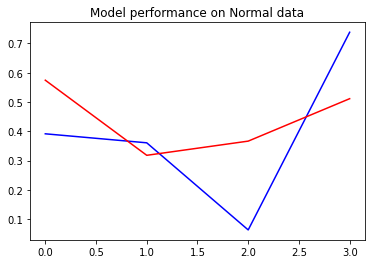

In [17]:
plt.plot(normal_test_data[1], 'b')
plt.plot(decoder_out[1], 'r')
plt.title("Model performance on Normal data")
plt.show()

In [18]:
encoder_out_a = model.encoder(anomalous_test_data).numpy() #8 unit representation of data
decoder_out_a = model.decoder(encoder_out_a).numpy()

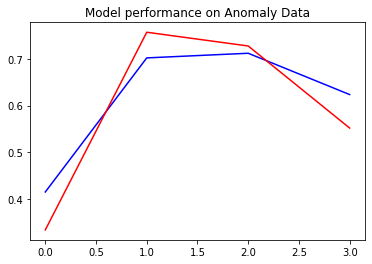

In [19]:
plt.plot(anomalous_test_data[2], 'b')
plt.plot(decoder_out_a[2], 'r')
plt.title("Model performance on Anomaly Data")
plt.show()

In [20]:
reconstruction = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_test_data)
#plt.hist(train_loss, bins=50)

In [21]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)
reconstruction_a = model.predict(anomalous_test_data)
train_loss_a = tf.keras.losses.mae(reconstruction_a, anomalous_test_data)

In [22]:
# plt.hist(train_loss_a, bins=50)
# plt.title("loss on anomaly test data")
# plt.show()

In [23]:
# plt.hist(train_loss, bins=50, label='normal')
# plt.hist(train_loss_a, bins=50, label='anomaly')
# plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
# plt.legend(loc='upper right')
# plt.title("Normal and Anomaly Loss")
# plt.show()

In [24]:
preds = tf.math.less(train_loss, threshold)
num = tf.math.count_nonzero(preds)
#Percentage of correclty classified normal
print(num/len(normal_test_data))

tf.Tensor(0.9651090342679127, shape=(), dtype=float64)


In [25]:
preds_a = tf.math.greater(train_loss_a, threshold)
num = tf.math.count_nonzero(preds_a)
#Percentage of correclty classified anomaly
print(num/len(anomalous_test_data))

tf.Tensor(0.025054129291679553, shape=(), dtype=float64)


# Other method

Separate normal and abnormal classes

Plot a normal and an abnormal modbus

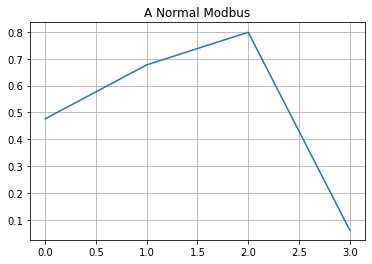

In [26]:
plt.grid()
plt.plot(np.arange(4), normal_train_data[0])
plt.title("A Normal Modbus")
plt.show()


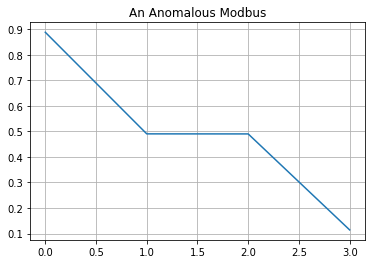

In [27]:
plt.grid()
plt.plot(np.arange(4), anomalous_train_data[0])
plt.title("An Anomalous Modbus")
plt.show()

### Build the model - OVERCOMPLETE AE
Dont use mean squared error in classification; cross entropy yes. However, training the AE with just normal data is not a classification task

### Training the AE with normal data

In [28]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu"),
      layers.Dense(2, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(4, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()


In [29]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
autoencoder.compile(optimizer=opt, loss='mae')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")


The training is just performed with normal instance. However, test is done with all the instances.

In [30]:
# USAGE OF TEST DATA TO VAL NOT FAIR
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=500,
          batch_size=128,
          validation_data=(test_data, test_data),
          shuffle=True,
          callbacks = [early_stopping])


Epoch 1/500
101/101 [==============================] - 1s 3ms/step - loss: 0.2502 - val_loss: 0.2496
Epoch 2/500
101/101 [==============================] - 0s 2ms/step - loss: 0.2498 - val_loss: 0.2490
Epoch 3/500
101/101 [==============================] - 0s 2ms/step - loss: 0.2492 - val_loss: 0.2485
Epoch 4/500
101/101 [==============================] - 0s 2ms/step - loss: 0.2485 - val_loss: 0.2478
Epoch 5/500
101/101 [==============================] - 0s 2ms/step - loss: 0.2478 - val_loss: 0.2470
Epoch 6/500
101/101 [==============================] - 0s 2ms/step - loss: 0.2469 - val_loss: 0.2461
Epoch 7/500
101/101 [==============================] - 0s 2ms/step - loss: 0.2458 - val_loss: 0.2449
Epoch 8/500
101/101 [==============================] - 0s 2ms/step - loss: 0.2445 - val_loss: 0.2436
Epoch 9/500
101/101 [==============================] - 0s 2ms/step - loss: 0.2432 - val_loss: 0.2423
Epoch 10/500
101/101 [==============================] - 0s 2ms/step - loss: 0.2418 - val_lo

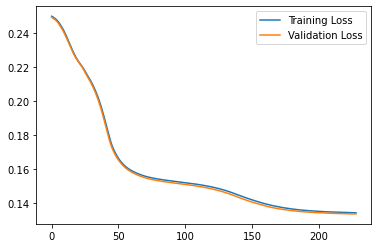

In [31]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


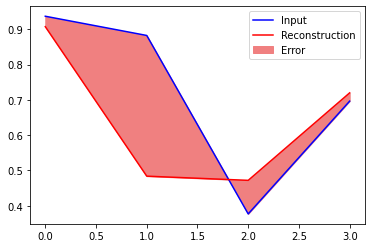

In [32]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(4), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


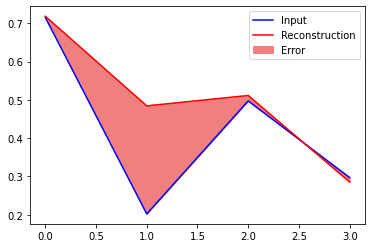

In [33]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(4), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


Detect anomalies by calculating the reconstruction lose of a fixed threshold.

Calculate the mean error for normal training examples to classify future anomalies if the error is greater than a StandDeviat of the train set.

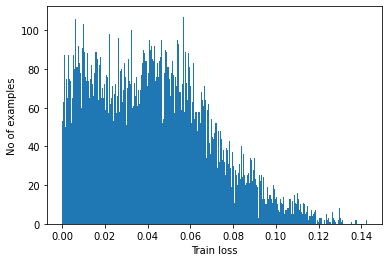

In [34]:
reconstruction = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mean_squared_error(reconstruction, normal_train_data)

plt.hist(train_loss[None,:], bins=300)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()


Select a value a std greater from the mean

In [35]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  0.07026269829564492


Error of abnormal MODBUS in test set

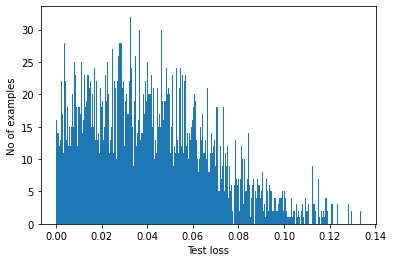

In [36]:
reconstruction_a = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mean_squared_error(reconstruction_a, anomalous_test_data)

plt.hist(test_loss[None, :], bins=300)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


In [37]:
print(reconstruction_a[0])
print(anomalous_test_data[0])
# print(reconstruction_a)
# print(reconstruction.shape)
# print(reconstruction_a.shape)

[0.71828043 0.4842743  0.5113664  0.2854116 ]
[0.71533872 0.20201419 0.49713841 0.29692984]


Classify instance as abnormal if the reconstruction error is greater than the threshold

In [38]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mean_squared_error(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions))) #sensitivity
  print("F1 = {}".format(f1_score(labels, predictions)))
  print("ROC_AUC = {}".format(roc_auc_score(labels, predictions)))



In [39]:
# Results dont make sense give more weight to anomaly class in the learning process
preds = predict(autoencoder, np.array(test_data), threshold)
print_stats(preds, test_labels)

Accuracy = 0.4980599099798231
Precision = 0.49990817263544535
Recall = 0.8419424682957006
F1 = 0.6273334869785665
ROC_AUC = 0.49682793196716496
